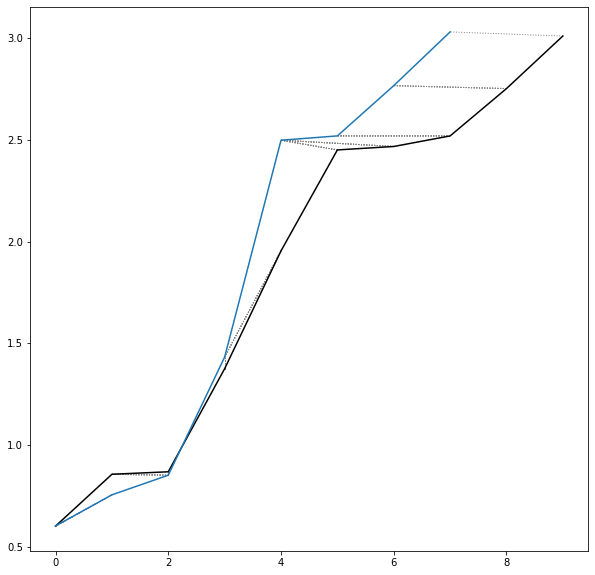

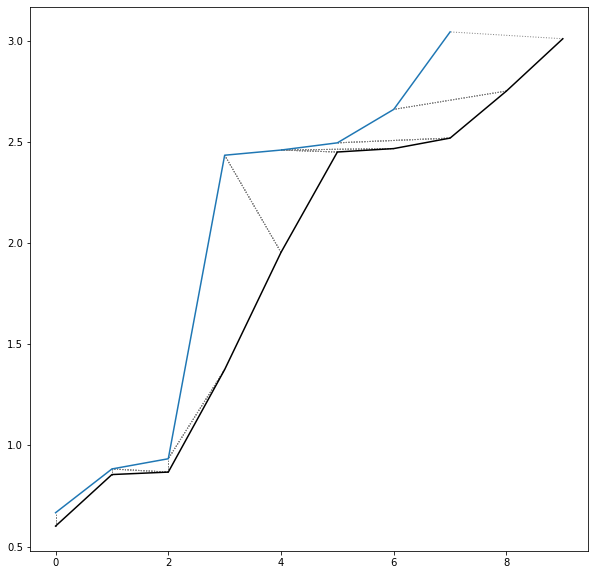

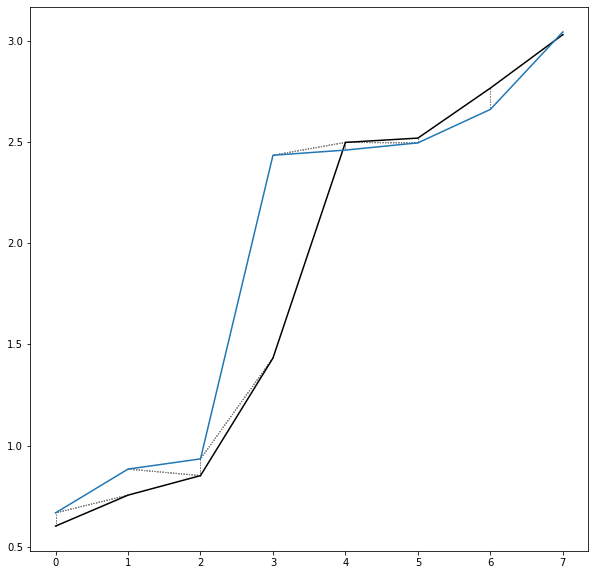

[0.6016761  0.85637493 0.86853807 1.37516225 1.95441234 2.45036627
 2.46727676 2.51915574 2.75182353 3.01008355]
[2.51926166 1.43266404 2.51687406 3.03035623 0.8518342  1.8422781
 0.60246092 2.76627813 2.49803248 0.75531219]
[1.84227809712324, 2.5168740581459956]
[0.88404687 0.66773401 2.49569048 2.66097217 1.87706707 2.43447829
 1.36502993 2.46003734 0.93444565 3.04386126]
[1.8770670671710483, 1.365029932905762]
[0.05626181118915823, 0.10702427124443549, 0.07667156908247355]


In [7]:
# https://dynamictimewarping.github.io/python/
from dtw import *
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

np.random.seed(1234)
x = np.random.uniform(0,np.pi,10)
x1 = x + np.random.normal(0,0.05,10)
x2 = x + np.random.normal(0,0.05,10)

np.random.shuffle(x)
np.random.shuffle(x1)
np.random.shuffle(x2)

x1c = np.random.choice(x1, size=len(x1)-2, replace=False)
x2c = np.random.choice(x2, size=len(x2)-2, replace=False)

x.sort()
x1c.sort()
x2c.sort()


alignment1 = dtw(x, x1c, keep_internals=True)
p1 = alignment1.plot(type="twoway")
alignment2 = dtw(x, x2c, keep_internals=True)
p2 = alignment2.plot(type="twoway")
alignment3 = dtw(x1c, x2c, keep_internals=True)
p3 = alignment3.plot(type="twoway")

print(x)
print(x1)
print(list(set(x1) - set(x1c)))
print(x2)
print(list(set(x2) - set(x2c)))

print([alignment1.normalizedDistance, alignment2.normalizedDistance, alignment3.normalizedDistance])


Generating Chirp...



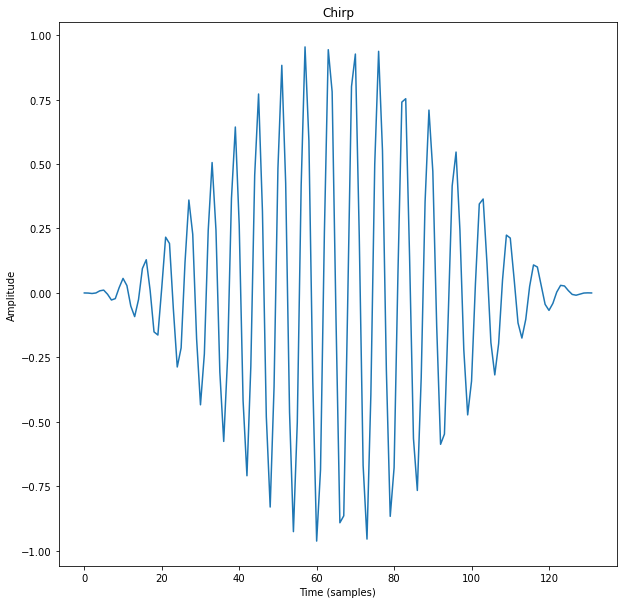

Chirp Generated.

Analyzing Signal...



FileNotFoundError: [Errno 2] No such file or directory: '75cmcorner.wav'

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import hilbert, chirp, windows
import scipy.io.wavfile as wavfile
from scipy.fftpack import fft
from scipy.signal import butter, lfilter
from scipy.signal import freqz

def generateChirp():
    print("Generating Chirp...\n")
    duration = .003
    fs = 44100.0
    samples = int(fs * duration)
    t = np.arange(samples) / fs

    signalC = chirp(t, 6000.0, t[-1], 8000.0)
    signalWinHann = np.multiply(signalC, windows.hann(signalC.shape[0]))

    #signalC *= (1.0 + 0.5 * np.sin(2.0 * np.pi * 3.0 * t))
    #analytic_signal = hilbert(signalC)
    #amplitude_envelope = np.abs(analytic_signal)

    signalWinHann = np.flipud(signalWinHann)
    plt.plot(signalWinHann, label='signal')
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.title("Chirp")
    #plt.plot(t, amplitude_envelope, label='envelope')
    plt.show()
    wavfile.write("audioHann.wav", 44100, signalWinHann)

    print("Chirp Generated.\n")
    return t, fs, signalWinHann

def analyzeRecording():
    print("Analyzing Signal...\n")
    # Read the audio files data and sampling rate recorded
    fs_rate, signalC = wavfile.read(r"75cmcorner.wav")
    print ("Frequency of Sample: ", fs_rate)
    # The number of channels as per the .WAV file
    numOfChannels = len(signalC.shape)
    print("Channels: ", numOfChannels)
    # If there is two channels we read them both and sum them
    if numOfChannels == 2:
        signalC = signalC.sum(axis=1) / 2
    # Store the amount of data points in signal
    samplesOfSignal = signalC.shape[0]
    print("Number of samples in the signal: ", samplesOfSignal)
    # Get the length of the recorded signal
    lengthInSec = samplesOfSignal / float(fs_rate)
    print("Length of signal in seconds: ", lengthInSec)
    # Time step is inverse of Frequency Sampling rate
    Tsample = 1/fs_rate
    print("Sampling Timesteps: ", Tsample)
    # Time Vector
    t = np.arange(0, lengthInSec, Tsample)

    # Compute FFT to get frequency components of signal
    FFT = abs(fft(signalC))
    # Get single sided FFT of the signal
    FFT_side = FFT[range(samplesOfSignal//2)]
    Freqs = scipy.fftpack.fftfreq(signalC.size, t[1]-t[0])
    # One side frequency range
    Freqs_Side = Freqs[range(samplesOfSignal//2)]
    print("\nAnalyzing Signal Completed.\n")

    # Plot the Actual Signal
    plt.subplot(311)
    p1 = plt.plot(t, signalC, "g")
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Plot the FFT of the Signal
    plt.subplot(312)
    plt.plot(Freqs, FFT, "r")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')

    # Plot only the one side of the FFT Spectrum
    plt.subplot(313)
    p3 = plt.plot(Freqs_Side, abs(FFT_side), "b") # plotting the positive fft spectrum
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')

    plt.show()
    return signalC, FFT_side

def matchedFilter(signalRec, signalWinHann, FFT_side):
    print("Applying Matched Filter...\n")

    signalMF = (np.abs(np.convolve(hilbert(signalWinHann), hilbert(signalRec), mode='valid')))
    padding = np.zeros(len(signalRec)//2)
    signalMF = np.concatenate((padding, signalMF, padding))
    print("Maximum peak at: " + str(signalMF.argmax()))
    plt.plot(signalMF, "m")
    plt.xlabel('Samples?')
    plt.ylabel('Amplitude')
    plt.show()
    print("\nMatched Filter Applied.\n")

    return

if __name__ == '__main__':
    # Generate a Chirp
    t, fs, signalWinHann = generateChirp()
    # Analyze recorded sound
    signalRec, FFT_side = analyzeRecording()
    # Apply matched filter.
    matchedFilter(signalRec, signalWinHann, FFT_side)